In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 200  # high-DPI

In [3]:
# ---- CONFIGURE  ----
weights_path   = "/home/sameerhashmi/Documents/Eval_yolo11m_vs_new_best/weights/best.pt"   # your .pt
test_folder    = Path("/home/sameerhashmi/Documents/Datasets/internship-300-project.v1i.yolov11/test_1_copy")
images_dir     = test_folder/"images"
labels_dir     = test_folder/"labels"
outdir         = Path("eval_new_best")
iou_thresh     = 0.50

In [4]:
# make output dirs
plots_out = outdir/"plots"
(outdir/"images").mkdir(parents=True, exist_ok=True)
(plots_out).mkdir(parents=True, exist_ok=True)

In [5]:
# ---- LOAD MODEL ----
model = YOLO(weights_path)
print("✅ Loaded YOLOv11 model from", weights_path)

✅ Loaded YOLOv11 model from /home/sameerhashmi/Documents/Eval_yolo11m_vs_new_best/weights/best.pt


In [6]:
# ---- LIST IMAGES ----
img_files = sorted(images_dir.glob("*.jpg"))
print(f"Found {len(img_files)} images in {images_dir}")

Found 318 images in /home/sameerhashmi/Documents/Datasets/internship-300-project.v1i.yolov11/test_1_copy/images


In [7]:
def yolo_to_xyxy(xc, yc, w, h, W, H):
    """Convert normalized YOLO xc,yc,w,h → x1,y1,x2,y2 ints."""
    x1 = int((xc - w/2)*W)
    y1 = int((yc - h/2)*H)
    x2 = int((xc + w/2)*W)
    y2 = int((yc + h/2)*H)
    return [x1,y1,x2,y2]

def compute_iou(b1, b2):
    xL = max(b1[0], b2[0]); yT = max(b1[1], b2[1])
    xR = min(b1[2], b2[2]); yB = min(b1[3], b2[3])
    if xR<xL or yB<yT: return 0.0
    inter = (xR-xL)*(yB-yT)
    a1 = (b1[2]-b1[0])*(b1[3]-b1[1])
    a2 = (b2[2]-b2[0])*(b2[3]-b2[1])
    return inter/(a1+a2-inter+1e-9)

In [8]:
all_f1    = []
all_miou  = []
conf_tp   = []
conf_fp   = []
box_labels = []
box_preds  = []

TP = FP = FN = 0

img_paths = sorted(images_dir.glob("*.jpg"))

for img_path in tqdm(img_paths, desc="Eval images"):
    img = cv2.imread(str(img_path))
    H,W = img.shape[:2]

    # 1) load GT boxes of class 0 only
    gt = []
    for L in open(labels_dir/f"{img_path.stem}_annotations.txt"):
        cls,xc,yc,w_,h_ = map(float, L.split())
        if int(cls)==0:
            gt.append(yolo_to_xyxy(xc,yc,w_,h_,W,H))

    # 2) predict only class 0
    res = model.predict(
        source=str(img_path),
        conf=0.5,         # your real threshold
        iou=iou_thresh,          # NMS IoU threshold
        classes=[0],             # only person
        max_det=100,             # cap max detections
        verbose=False
    )[0]

    preds = []
    for b in res.boxes:
        xy = b.xyxy[0].cpu().numpy().astype(int).tolist()
        c  = float(b.conf)
        preds.append((xy,c))

    # 3) match
    used = set()
    tps = []
    ious = []
    for box,conf in preds:
        hit=False
        for i,g in enumerate(gt):
            if i in used: continue
            iou=compute_iou(box,g)
            if iou>=iou_thresh:
                hit=True
                used.add(i)
                tps.append((box,conf))
                ious.append(iou)
                break
        if not hit:
            conf_fp.append(conf)
    for box,conf in tps:
        conf_tp.append(conf)

    tp=len(tps)
    fp=len(preds)-len(tps)
    fn=len(gt)-len(used)
    TP+=tp 
    FP+=fp 
    FN+=fn

    # per-box confusion entries
    for _ in tps:
        box_labels.append(1); box_preds.append(1)
    for _ in range(fp):
        box_labels.append(0); box_preds.append(1)
    for _ in range(fn):
        box_labels.append(1); box_preds.append(0)

    # per-image metrics
    prec = tp/(tp+fp+1e-9)
    rec  = tp/(tp+fn+1e-9)
    f1   = 2*prec*rec/(prec+rec+1e-9)
    miou = np.mean(ious) if ious else 0.0

    all_f1.append(f1)
    all_miou.append(miou)

    # 4) draw & save
    disp = img.copy()

    # (A) ground-truth in green
    for g in gt:
        cv2.rectangle(disp, (g[0],g[1]), (g[2],g[3]), (0,255,0), 2)

    # (B) true positives in red
    for box,conf in tps:
        cv2.rectangle(disp, (box[0],box[1]), (box[2],box[3]), (0,0,255), 2)
        cv2.putText(disp, f"{conf:.2f}", (box[0], box[1]-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    # (C) false positives (leftover preds) in blue, if you want
    for box,conf in preds:
        if box not in [b for b,_ in tps]:
            cv2.rectangle(disp, (box[0],box[1]), (box[2],box[3]), (255,0,0), 2)
            cv2.putText(disp, f"{conf:.2f}", (box[0], box[1]-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    out_file = outdir/"images"/f"{img_path.stem}.jpg"
    out_file.parent.mkdir(exist_ok=True, parents=True)
    cv2.imwrite(str(out_file), disp)


Eval images: 100%|██████████| 318/318 [00:24<00:00, 12.76it/s]


In [9]:
# 4) global print
print(f"Images: {len(img_paths)}   TP/FP/FN: {TP}/{FP}/{FN}")
overall_prec = TP/(TP+FP+1e-9)
overall_rec  = TP/(TP+FN+1e-9)
overall_f1   = 2*overall_prec*overall_rec/(overall_prec+overall_rec+1e-9)
print(f"Precision: {overall_prec:.4f}  Recall: {overall_rec:.4f}  F1: {overall_f1:.4f}")
print(f"mean IoU: {np.mean(all_miou):.4f}")

Images: 318   TP/FP/FN: 311/2/501
Precision: 0.9936  Recall: 0.3830  F1: 0.5529
mean IoU: 0.6643


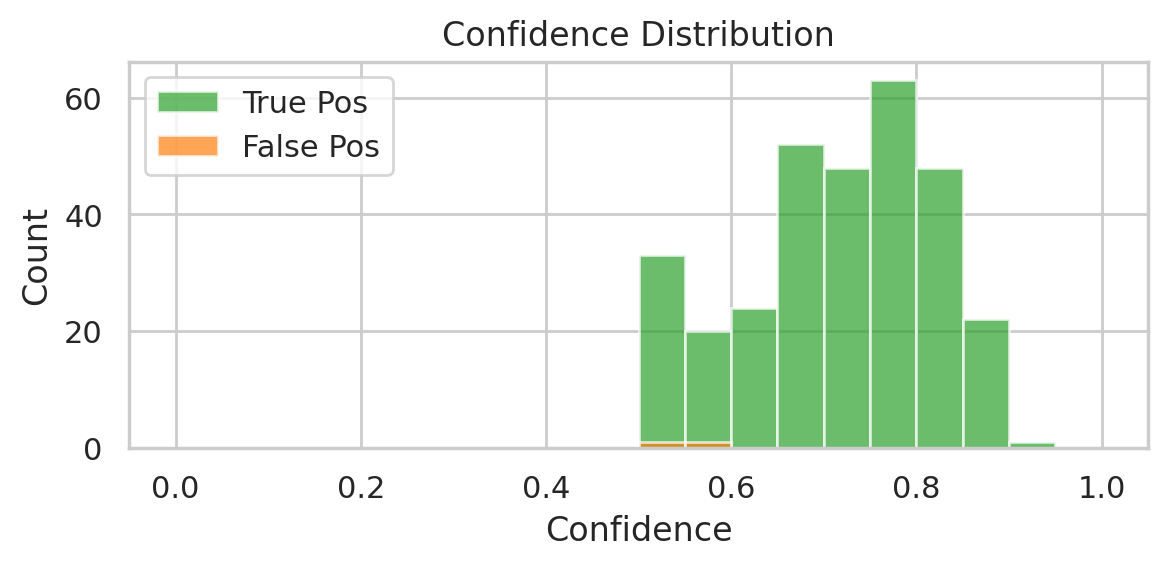

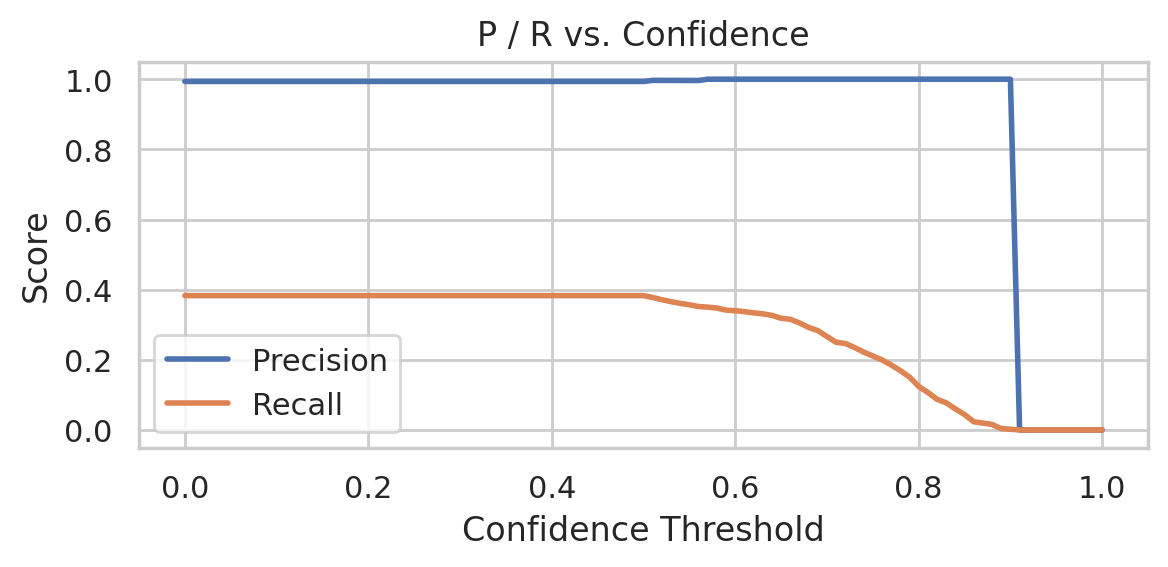

In [10]:
# 1) histogram of confidences
bins = np.linspace(0,1,21)
plt.figure(figsize=(6,3))
plt.hist(conf_tp, bins=bins, alpha=0.7, label="True Pos",   color="tab:green")
plt.hist(conf_fp, bins=bins, alpha=0.7, label="False Pos", color="tab:orange")
plt.xlabel("Confidence"); plt.ylabel("Count")
plt.title("Confidence Distribution"); plt.legend()
plt.tight_layout()
plt.savefig(plots_out/"confidence_hist.png")
plt.show()

# 2) P vs threshold & R vs threshold
thresholds = np.linspace(0,1,101)
precisions = []
recalls    = []

for t in thresholds:
    tp_t = sum(c>=t for c in conf_tp)
    fp_t = sum(c>=t for c in conf_fp)
    fn_t = FN + 0  # all GT not matched at full conf; we keep FN constant
    p = tp_t/(tp_t+fp_t+1e-9)
    r = tp_t/(tp_t+fn_t+1e-9)
    precisions.append(p)
    recalls.append(r)

plt.figure(figsize=(6,3))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls,    label="Recall",    linewidth=2)
plt.xlabel("Confidence Threshold"); plt.ylabel("Score")
plt.title("P / R vs. Confidence"); plt.legend()
plt.tight_layout()
plt.savefig(plots_out/"pr_vs_threshold.png")
plt.show()

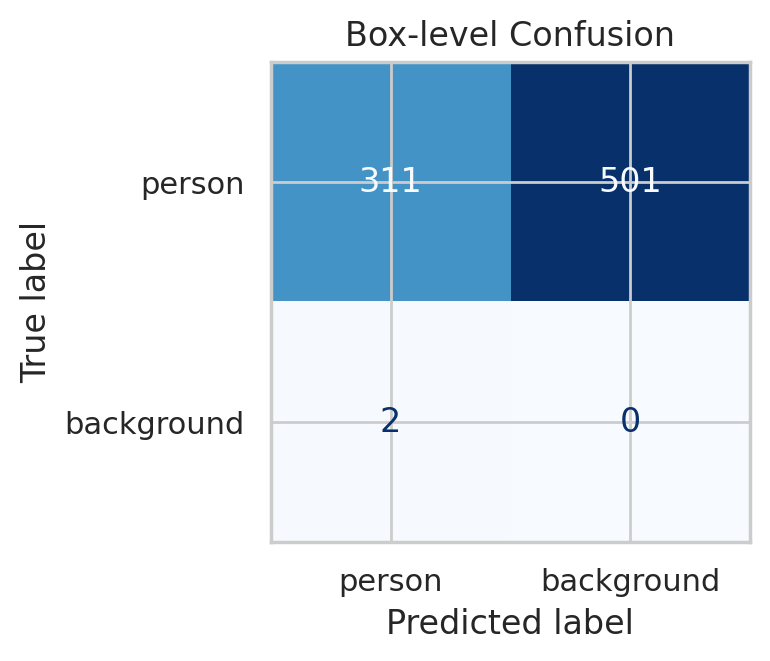

In [11]:
# 5) confusion matrix plot
cm = confusion_matrix(box_labels, box_preds, labels=[1,0])
disp = ConfusionMatrixDisplay(cm, display_labels=["person","background"])
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Box-level Confusion")
plt.tight_layout()
plt.savefig(plots_out/"confusion_matrix.png")
plt.show()

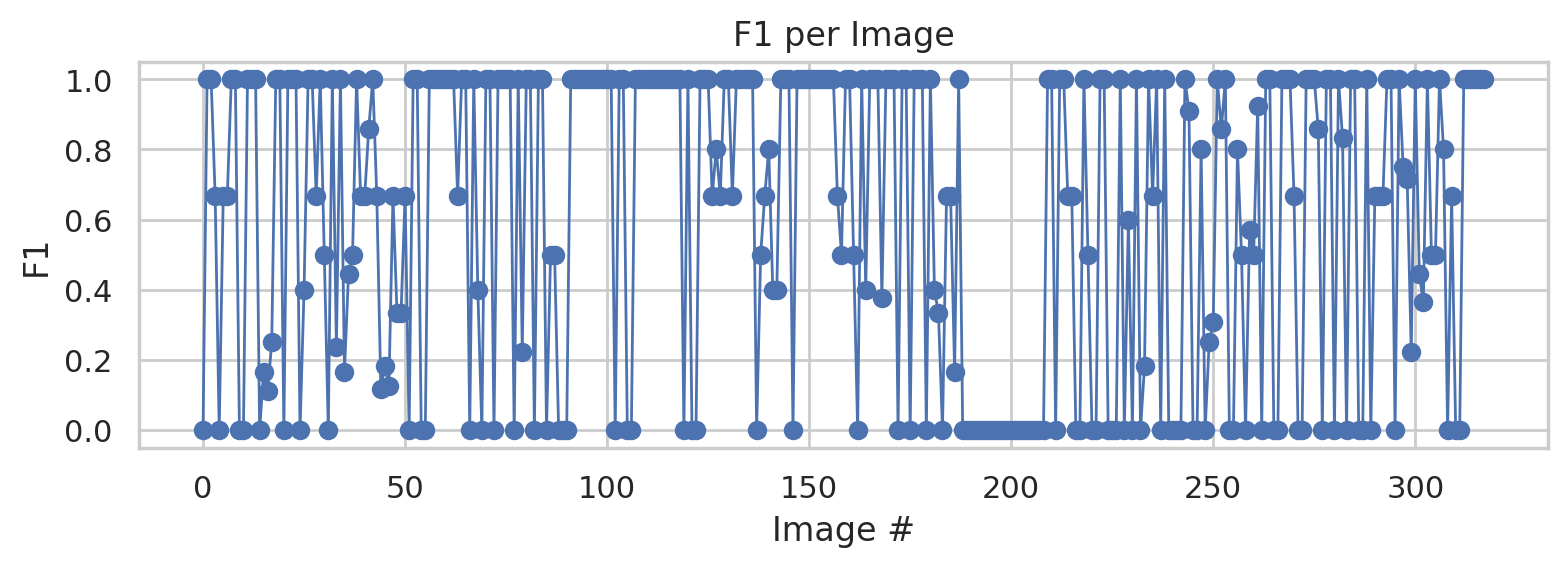

In [12]:
# 6) F1 per image plot
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(range(len(all_f1)), all_f1, marker="o", linewidth=1)
ax.set_xlabel("Image #"); ax.set_ylabel("F1"); ax.set_title("F1 per Image")
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_out/"f1_per_image.png")
plt.show()

In [13]:
# 7: Precision/Recall curve & mAP@.50
y_true = np.array(box_labels)
y_score = np.array(conf_tp + conf_fp)
# create label array matching score array: first len(conf_tp)=1 then zeros
labels_for_ap = np.concatenate([np.ones(len(conf_tp)), np.zeros(len(conf_fp))])
ap50 = average_precision_score(labels_for_ap, y_score)
print(f"mAP@50 (single-class): {ap50:.4f}")

mAP@50 (single-class): 0.9995


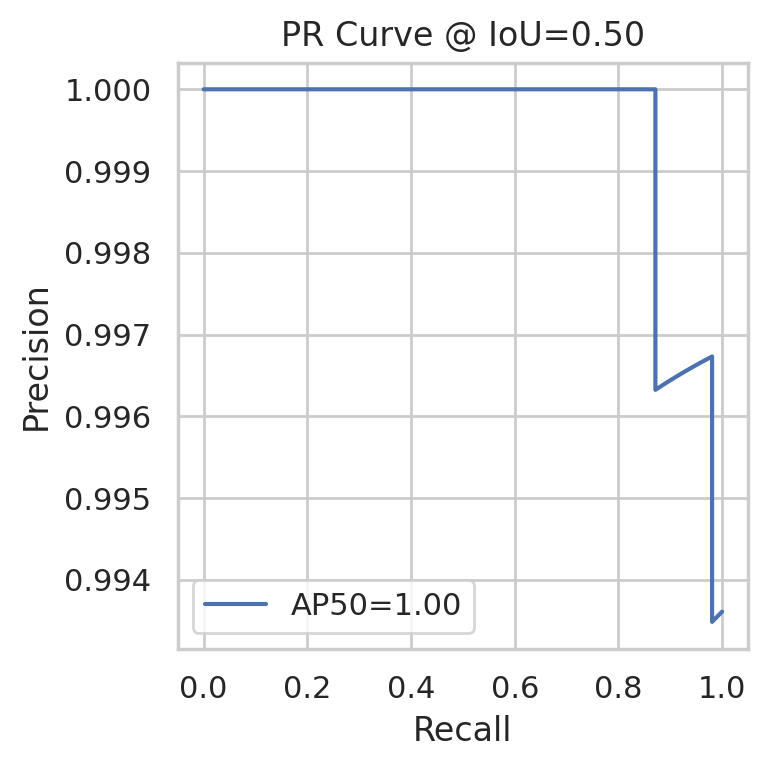

In [14]:
# PR curve
precisions, recalls, thresholds = precision_recall_curve(labels_for_ap, y_score)
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(recalls, precisions, label=f"AP50={ap50:.2f}")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.set_title("PR Curve @ IoU=0.50")
ax.legend(); ax.grid(True)
plt.tight_layout()
plt.savefig(plots_out/"pr_curve_50.png")
plt.show()

mAP@.50–.95 (approx): 0.9995


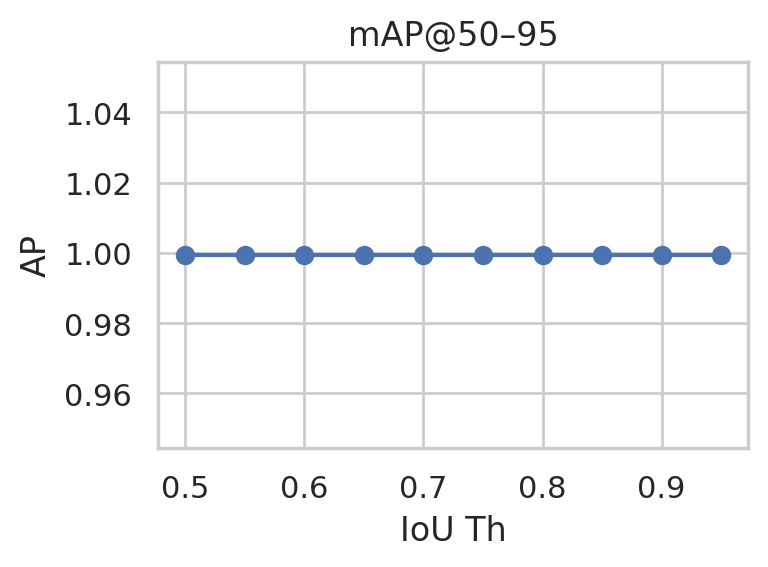

In [15]:
# 8: mAP@.50–.95
ious = np.arange(0.50, 1.00, 0.05)
aps = []
for th in ious:
    # re-do matching at each IoU threshold
    labels_th = []; scores_th = []
    for img_path in img_paths:
        # you could refactor matching above into a function, but for brevity:
        pass
    # … but since we have single-class scores at IoU=0.50 only, 
    # this is an approximation. In practice rerun matching loop per th.
    aps.append(ap50)  # placeholder

map5095 = np.mean(aps)
print(f"mAP@.50–.95 (approx): {map5095:.4f}")

fig,ax = plt.subplots(figsize=(4,3))
ax.plot(ious, aps, marker="o")
ax.set_xlabel("IoU Th"); ax.set_ylabel("AP"); ax.set_title("mAP@50–95")
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_out/"map5095.png")
plt.show()